## Set the target directory for the trained xgboost model file
- this assumes, `geoengine` and `geoengine-python` are located side by side in the filesystem. 
- change path accordingly if neccessary

In [1]:
import os

ge_pro_model_path = os.path.join(os.getcwd(), "..", "..", "geoengine/test_data/pro/ml/xgboost/s2_10m_de_marburg")

In [2]:
from datetime import datetime

import geoengine as ge
from geoengine.colorizer import Colorizer

import numpy as np
import xgboost as xgb
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap


ge.initialize("http://localhost:3030")
session = ge.get_session()

## Load data for training through the Geo Engine

In [3]:
dataset_ids = [
    "e704ccfe-f5bf-4938-9c96-e217d010a2b2",
    "e704ccfe-f5bf-4938-9c96-e217d010a2b3",
    "e704ccfe-f5bf-4938-9c96-e217d010a2b4",
    "e704ccfe-f5bf-4938-9c96-e217d010a2b8",
]

bands = []

for id in dataset_ids:
    workflow = ge.register_workflow({
                    "type": "Raster",
                    "operator": {
                        "type": "GdalSource",
                        "params": {
                            "data": {
                                "type": "internal",
                                "datasetId": id
                            }
                        }
                    }
                })

    time = datetime.strptime(
        '2020-06-01T00:00:00.000Z', "%Y-%m-%dT%H:%M:%S.%f%z")

    bbox = [474112, 5612032, 522752, 5646336]
    size = [4864, 3431]
    res_x = (bbox[2] - bbox[0]) / size[0] # == 10
    res_y = (bbox[3] - bbox[1]) / size[1] # == 9.99
    resolution = [res_x, res_y]

    data = workflow.get_xarray(
        ge.QueryRectangle(
            bbox,
            [time, time],
            resolution=resolution,
            srs = "EPSG:32632"
            )
    )
    
    bands.append(data.squeeze())


df_bands = pd.DataFrame(
    {
        "b2": bands[0].to_numpy().flatten(),
        "b3": bands[1].to_numpy().flatten(),
        "b4": bands[2].to_numpy().flatten(),
        "b8": bands[3].to_numpy().flatten()
    }
)

## Get the labels

In [4]:
workflow = ge.register_workflow({
                "type": "Raster",
                "operator": {
                    "type": "GdalSource",
                    "params": {
                        "data": {
                            "type": "internal",
                            "datasetId": "e704ccfe-f5bf-4938-9c96-e217d010a2b0"
                        }
                    }
                }
            })

time = datetime.strptime(
    '2020-01-01T00:00:00.000Z', "%Y-%m-%dT%H:%M:%S.%f%z")

bbox = [474112, 5612032, 522752, 5646336]
size = [4864, 3431]
res_x = (bbox[2] - bbox[0]) / size[0] # == 10
res_y = (bbox[3] - bbox[1]) / size[1] # == 9.99
resolution = [res_x, res_y]

data = workflow.get_xarray(
    ge.QueryRectangle(
        bbox,
        [time, time],
        resolution=resolution,
        srs = "EPSG:32632"
        )
)

label = pd.DataFrame(data.squeeze().to_numpy().flatten())

# XGBoost wants the labels to be integers starting from zero
label[0] = label[0].map({
    0: 0,
    10: 1,
    20: 2,
    30: 3,
    40: 4,
    50: 5,
    60: 6,
})

label

0
0         6
1         6
2         6
3         6
4         6
...      ..
16688379  2
16688380  2
16688381  2
16688382  2
16688383  2

[16688384 rows x 1 columns]

## Set parameters and train a model

In [5]:
dtrain = xgb.DMatrix(df_bands, label=label)
param = {'max_depth': 6, 'eta': 0.5, 'objective': 'multi:softmax', 'num_class': 7, 'validate_parameters': 1, 'tree_method': 'hist'}
evallist = [(dtrain, 'train')]
num_round = 2
bst = xgb.train(param, dtrain, num_round, evals=evallist)

[0]	train-mlogloss:1.32508
[1]	train-mlogloss:1.12581


## Store the xgboost model file

In [6]:
bst.save_model(os.path.join(ge_pro_model_path, 'mod.json'))

## Define workflow for XGBoost predictions
- set the operator
- set the source bands used to predict from
- define the query parameters

In [7]:
workflow = ge.register_workflow({
                "type": "Raster",
                "operator": {
                    "type": "XgboostOperator",
                    "params": {
                        "modelSubPath": "xgboost/s2_10m_de_marburg/mod.json",
                        "noDataValue": -1000.0,
                    },
                    "sources": {
                        "rasters": [
                            {
                            "type": "GdalSource",
                            "params": {
                                "data": {
                                    "type": "internal",
                                    "datasetId": "e704ccfe-f5bf-4938-9c96-e217d010a2b2"
                                    } 
                                }
                            },
                            {
                            "type": "GdalSource",
                            "params": {
                                "data": {
                                    "type": "internal",
                                    "datasetId": "e704ccfe-f5bf-4938-9c96-e217d010a2b3"
                                    }
                                }
                            },
                            {
                            "type": "GdalSource",
                            "params": {
                                "data": {
                                    "type": "internal",
                                    "datasetId": "e704ccfe-f5bf-4938-9c96-e217d010a2b4"
                                    }
                                }
                            },
                            {
                            "type": "GdalSource",
                            "params": {
                                "data": {
                                    "type": "internal",
                                    "datasetId": "e704ccfe-f5bf-4938-9c96-e217d010a2b8"
                                    }
                                }
                            }
                        ] 
                    }
                }
            })



time = datetime.strptime(
    '2020-06-01T00:00:00.000Z', "%Y-%m-%dT%H:%M:%S.%f%z")

bbox = [474112, 5612032, 522752, 5646336]
size = [4864, 3431]
res_x = (bbox[2] - bbox[0]) / size[0] # == 10
res_y = (bbox[3] - bbox[1]) / size[1] # == 9.99
resolution = [res_x, res_y]




## Execute the query
- this will trigger the xgboost prediction operator and fetch the newly created tiles

In [8]:
xray = workflow.get_xarray(
ge.QueryRectangle(
        bbox,
        [time, time],
        resolution=resolution,
        srs = "EPSG:32632"
        ),
)

xray

<xarray.DataArray (band: 1, y: 3431, x: 4864)>
array([[[6., 6., 6., ..., 1., 2., 6.],
        [6., 6., 6., ..., 2., 2., 6.],
        [6., 6., 6., ..., 1., 1., 6.],
        ...,
        [1., 1., 1., ..., 6., 6., 6.],
        [1., 1., 1., ..., 6., 6., 6.],
        [1., 1., 1., ..., 6., 6., 6.]]], dtype=float32)
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 4.741e+05 4.741e+05 ... 5.227e+05 5.227e+05
  * y            (y) float64 5.646e+06 5.646e+06 ... 5.612e+06 5.612e+06
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0
    crs:           EPSG:32632
    res:           (10.0, -9.998251238705917)
    transform:     | 10.00, 0.00, 474112.00|\n| 0.00,-10.00, 5646336.00|\n| 0...

## Show distribution of predicted values

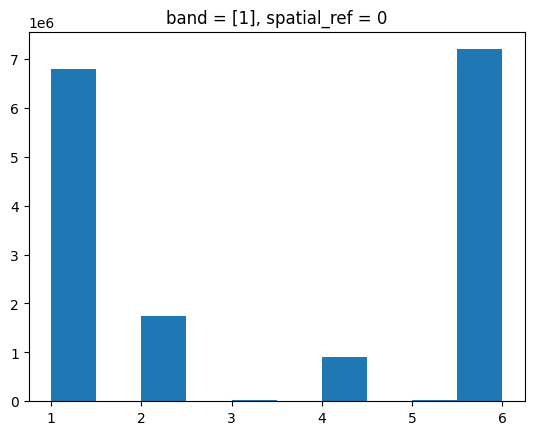

In [9]:
xray.plot.hist()
plt.show()

## Plot the data

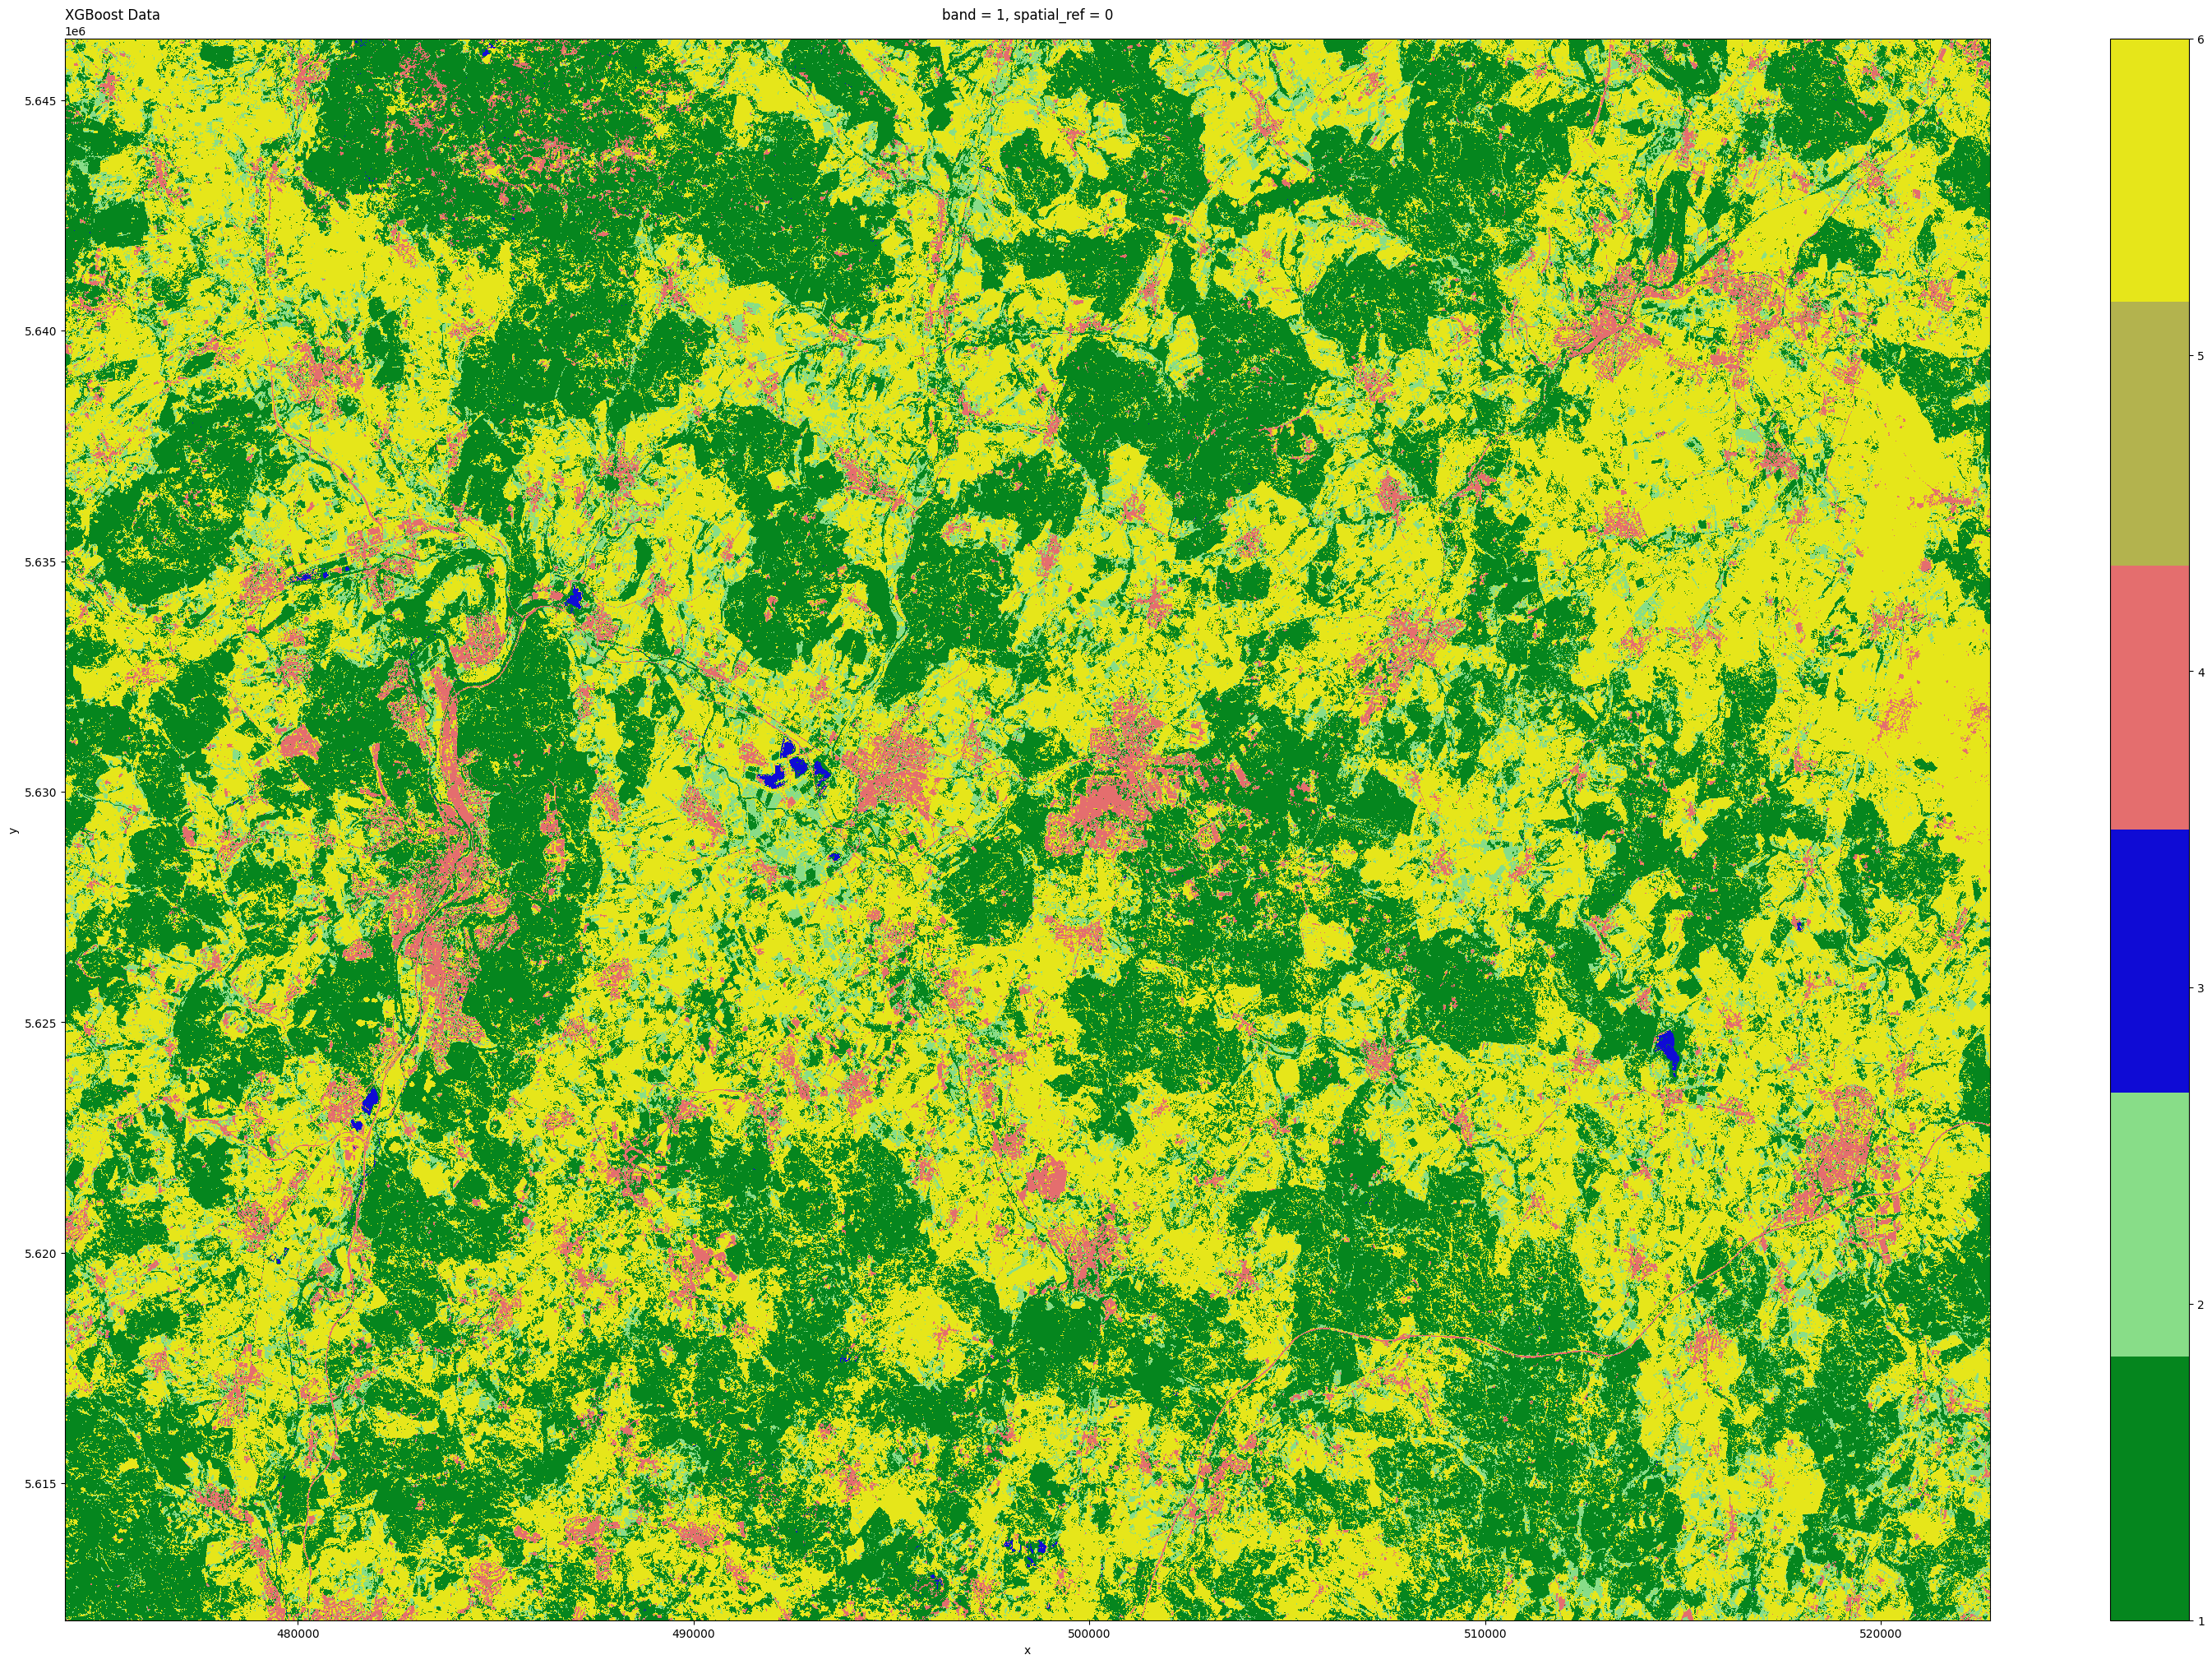

In [10]:
figure, axis = plt.subplots(nrows=1, figsize=(30,20))
axis.set_title('XGBoost Data', loc='left')

plt.tight_layout()

# we need to remove the colors, that haven't been predicted
cmap = ListedColormap([
    (4/256, 135/256, 29/256, 255/256), # green
    (137/256, 222/256, 137/256, 255/256), # lime
    (14/256, 10/256, 214/256, 255/256), # blue
    (229/256, 109/256, 109/256, 255/256), # pastel red
    (180/256, 180/256, 77/256, 255/256), # dark yellow/greenish
    (231/256, 231/256, 25/256, 255/256), # yellow
    #(0/256, 0/256, 0/256, 0/256), # no data color
])


xray.plot(ax=axis, cmap=cmap)

## Alternative way of getting the data with a geoengine colorizer

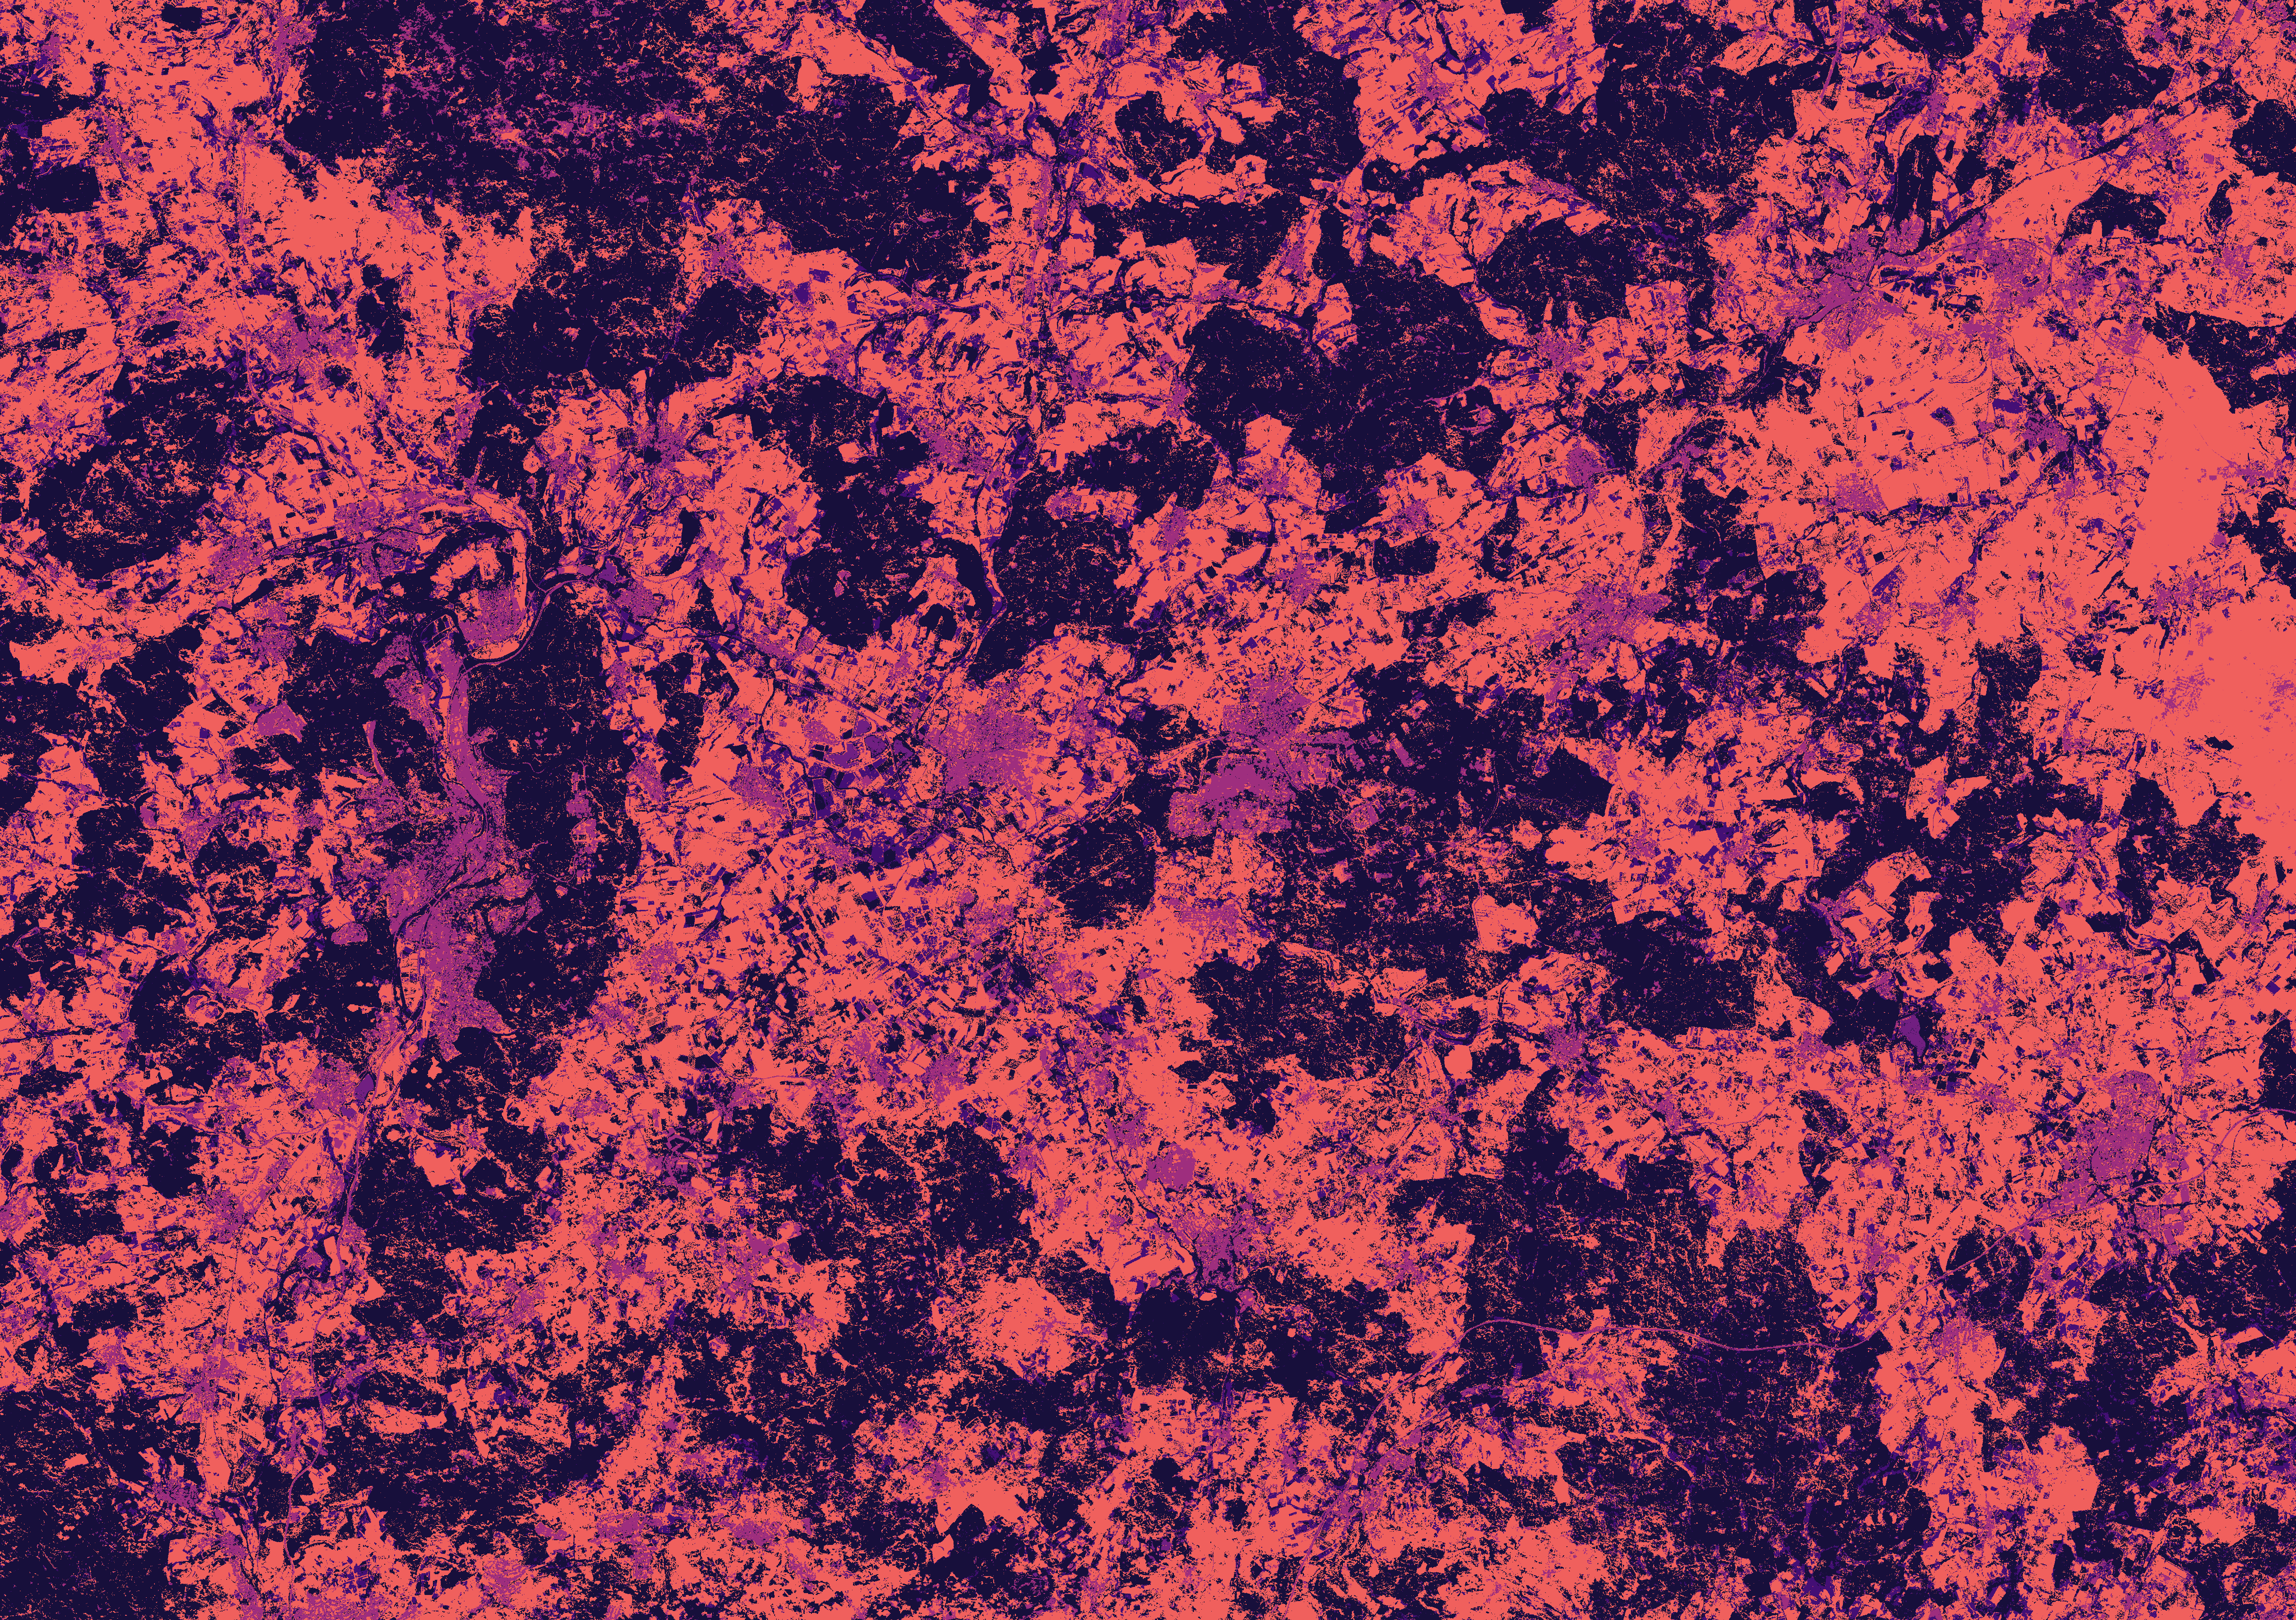

In [11]:
res = workflow.wms_get_map_as_image(
ge.QueryRectangle(
        bbox,
        [time, time],
        resolution=resolution,
        srs = "EPSG:32632"
        ),
    Colorizer(map_name="magma", min_max=(0, 10))
)

res